In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision. transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor' ] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
image_permuted = image.permute(1, 2, 0)
image_permuted.shape
# plt.imshow(image.permute(1, 2, 0), cmap='gray')
#permute is use to change the dimension
# earlier it was (1, 28, 28)
# afetr permute its becaome (28, 28, 1)
# We changed it because Tensor expects color chanel in last Dimention


image.shape: torch.Size([1, 28, 28])


torch.Size([28, 28, 1])

Label: 5


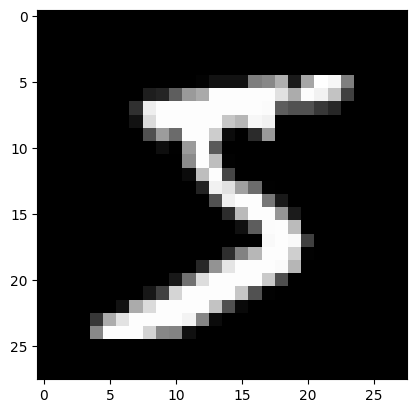

In [4]:
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [5]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
# train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# in the above line I used pin_memory=True to to improve data transfer speed from CPU to GPU.
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


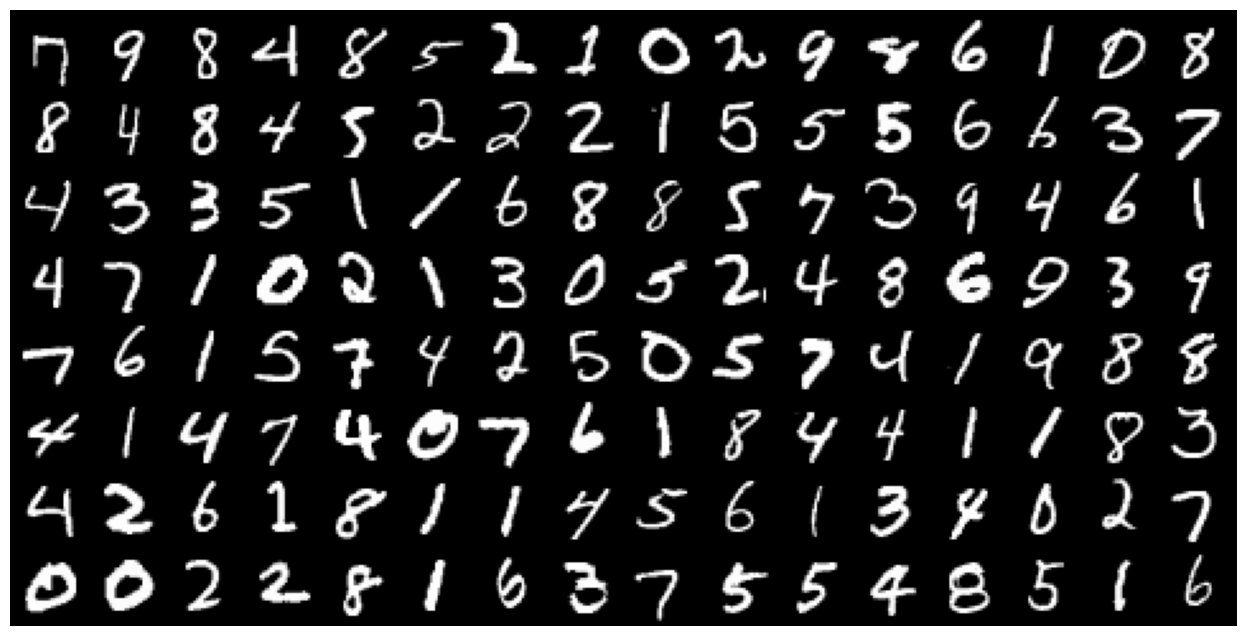

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break


In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [10]:
input_size = inputs.shape[-1]
hidden_size = 32

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [14]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [15]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [16]:
relu_outputs = F.relu(layer1_outputs)
print('relu_outputs.shape', relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

relu_outputs.shape torch.Size([128, 32])
min(layer1_outputs): -0.7388440370559692
min(relu_outputs): 0.0


In [17]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [18]:
print(image.shape)
print(relu_outputs.shape)

torch.Size([1, 28, 28])
torch.Size([128, 32])


In [19]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [20]:
# same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [21]:
# create a single layer to replace the two linear layer1_outputs
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [22]:
# same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [23]:
torch.allclose(outputs2, outputs3, 1e-3)

True

In [24]:
class MnistModel(nn.Module):
    #Feed Forward neural network with 1 hidden layer
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        #Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        #Get intermidiate outputs using hidden layer
        out = self.linear1(xb)
        #Apply activation function
        out = F.relu(out)
        #Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  #generating predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  #generate predictions
        loss = F.cross_entropy(out, labels)  #calculate loss
        acc = accuracy(out, labels)    #calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  #Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()   # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
input_size = 784
hidden_size = 32 # we can change this
num_classes = 10

In [27]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [28]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [29]:
for images, labels in train_loader:
    outputs = model(images)
    break

loss = F.cross_entropy(outputs, labels)
print('Loss:', loss.item())
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3212814331054688
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0845,  0.0821,  0.0998,  0.2427, -0.1323,  0.0696, -0.1670, -0.0367,
         -0.2614,  0.1064],
        [-0.0558,  0.0214,  0.0706,  0.2537, -0.1444,  0.0005, -0.0984, -0.1117,
         -0.2311,  0.0986]])


In [30]:
torch.cuda.is_available()

c:\Users\jaisw\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: cudaGetDeviceCount() returned cudaErrorNotSupported, likely using older driver or on CPU machine (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:88.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [31]:
def get_default_device():
    #pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [32]:
device = get_default_device()
device

device(type='cpu')

In [33]:
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [34]:
for images, labels in train_loader:
    print(image.shape)
    print(images.device)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([1, 28, 28])
cpu
cpu


In [35]:
class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        #Yeild a betach of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)


    def __len__(self):
        #number of Batches
        return len(self.dl)

In [36]:
def some_number():
    yield 10
    yield 20
    yield 30

for value in some_number():
    print(value)

10
20
30


In [37]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [38]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

c:\Users\jaisw\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


xb.device: cpu
yb: tensor([8, 2, 2, 1, 2, 5, 2, 2, 8, 4, 3, 8, 0, 3, 9, 0, 9, 9, 2, 2, 1, 8, 9, 0,
        3, 2, 9, 6, 1, 1, 6, 6, 3, 3, 6, 5, 1, 1, 4, 1, 8, 3, 2, 3, 4, 3, 6, 7,
        1, 6, 4, 4, 6, 9, 7, 8, 5, 2, 9, 1, 6, 0, 7, 3, 1, 2, 7, 8, 9, 7, 5, 2,
        3, 0, 9, 2, 9, 0, 6, 3, 6, 6, 6, 4, 8, 6, 8, 7, 9, 6, 4, 8, 2, 8, 6, 5,
        0, 1, 0, 2, 9, 0, 7, 2, 1, 5, 0, 4, 7, 0, 2, 1, 9, 2, 1, 6, 6, 8, 1, 6,
        5, 1, 7, 9, 1, 1, 1, 4, 8, 1, 3, 2, 7, 6, 8, 6, 6, 2, 1, 9, 0, 8, 2, 5,
        6, 4, 1, 8, 1, 8, 4, 2, 4, 8, 7, 4, 2, 2, 7, 5, 1, 2, 1, 7, 6, 7, 2, 2,
        6, 4, 7, 1, 1, 7, 3, 0, 7, 7, 3, 4, 8, 2, 4, 0, 7, 7, 2, 9, 9, 6, 7, 4,
        6, 8, 7, 5, 8, 7, 5, 1, 3, 7, 5, 9, 5, 7, 6, 6, 9, 6, 1, 1, 0, 5, 2, 3,
        7, 9, 2, 3, 8, 1, 3, 2, 6, 2, 4, 1, 1, 5, 4, 9, 3, 2, 0, 5, 2, 0, 9, 6,
        1, 8, 1, 4, 9, 5, 8, 9, 6, 7, 5, 2, 1, 5, 3, 9])


In [39]:
def evaluate(model, val_loader):
    #Evaluates the model's performance on the validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    #training the model using gradient descent
    optimizer = opt_func(model.parameters(), lr)
    history = []# for recording epoch-wise results
    for epoch in range(epochs):

        # training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation Phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [40]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [41]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.295253276824951, 'val_acc': 0.1474609375}]

In [42]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2227, val_acc: 0.9353
Epoch [1], val_loss: 0.1593, val_acc: 0.9536
Epoch [2], val_loss: 0.1381, val_acc: 0.9593
Epoch [3], val_loss: 0.1744, val_acc: 0.9482
Epoch [4], val_loss: 0.1294, val_acc: 0.9626


In [43]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1115, val_acc: 0.9665
Epoch [1], val_loss: 0.1089, val_acc: 0.9701
Epoch [2], val_loss: 0.1096, val_acc: 0.9683
Epoch [3], val_loss: 0.1076, val_acc: 0.9695
Epoch [4], val_loss: 0.1078, val_acc: 0.9690


In [44]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1069, val_acc: 0.9695
Epoch [1], val_loss: 0.1067, val_acc: 0.9694
Epoch [2], val_loss: 0.1067, val_acc: 0.9696
Epoch [3], val_loss: 0.1067, val_acc: 0.9693
Epoch [4], val_loss: 0.1064, val_acc: 0.9694


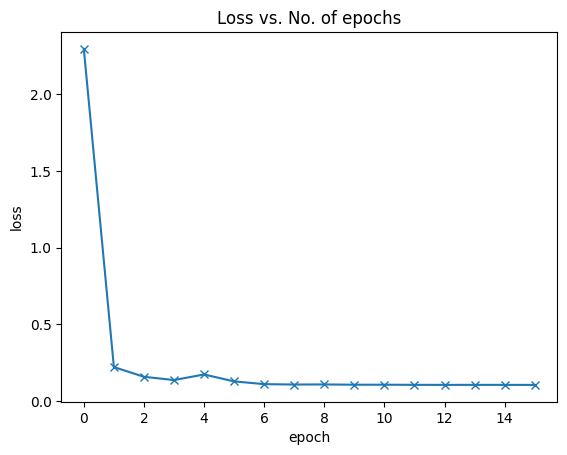

In [45]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

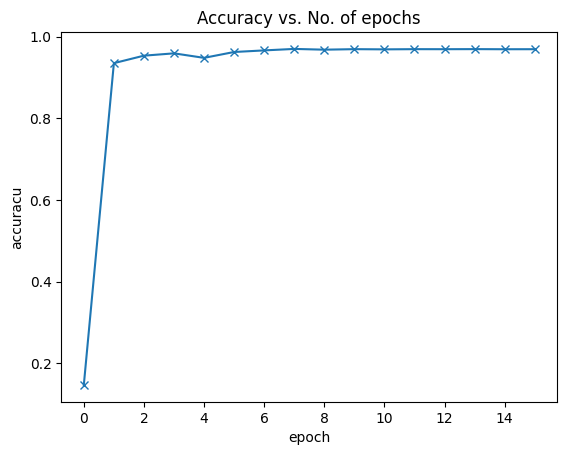

In [46]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracu')
plt.title('Accuracy vs. No. of epochs');

In [47]:
#Define test dataset
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

In [50]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


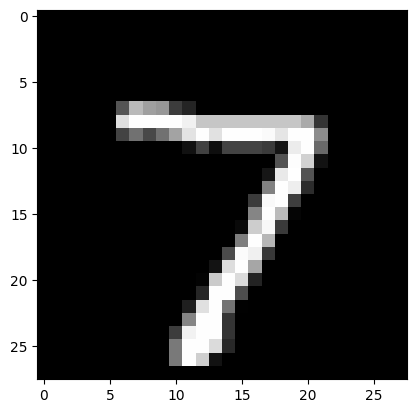

In [51]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


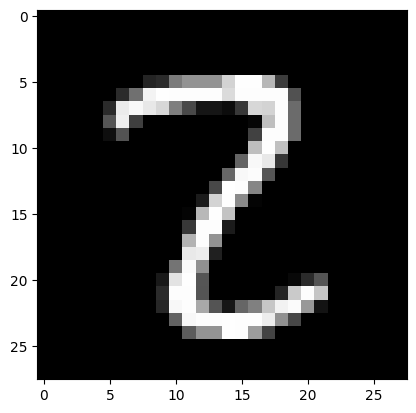

In [52]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


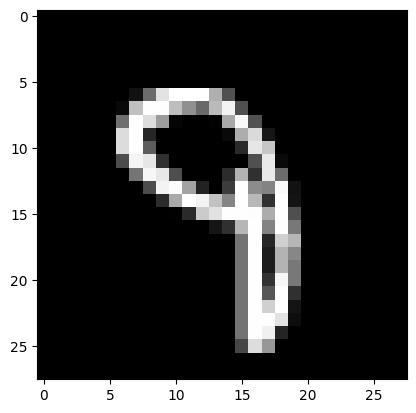

In [53]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [54]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09632737934589386, 'val_acc': 0.9720703363418579}

In [55]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')